# Abstract

# Loading the Model and Packages

Source Code: 

In [80]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
from kagglehub import KaggleDatasetAdapter
from AdvancedOptimization import LogisticRegression, NewtonOptimizer, GradientDescentOptimizer
plt.style.use('seaborn-v0_8-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Basic Function on Simple Data

Before we move on to advanced experiments with our Newton optimizer, we will first check that our new Logistic Regression class can converge on data that we know standard Logistic Regression can converge on. Looking back at Blog 5, we will use a small dataset to test the basic function of our Logistic Regression model using the exact function to generate our data as we did in Blog 5. 

In [81]:
# define a function to generate random data points
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# generate our test data and convert to float
X, y = classification_data()
X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)

C:\Users\miceo\AppData\Local\Temp\ipykernel_29368\2062740850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


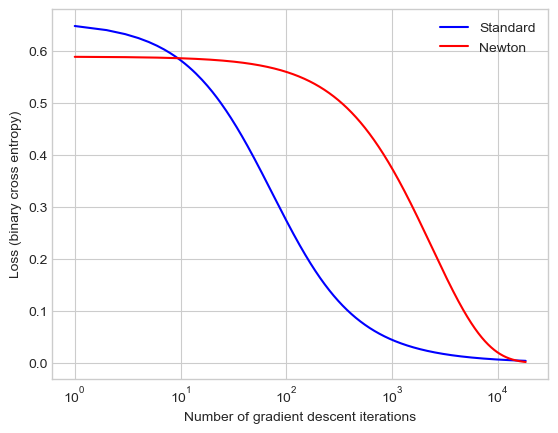

In [82]:
# instantiate our new Logisitic Regression model with a Newton Optimizer and compare it to the Gradient Descent Optimizer
LR1 = LogisticRegression()
LR2 = LogisticRegression()

opt1 = GradientDescentOptimizer(LR1)
opt2 = NewtonOptimizer(LR2)

# for keeping track of loss values
loss1_vec = []
loss2_vec = []

# keeps track of mean loss between the two algorithms
mean_loss = 1

# training loop to iterate through optimization steps
while (mean_loss > 0):
    
    # Track loss values (convert tensors to scalars)
    loss1_vec.append(LR1.loss(X, y))
    loss2_vec.append(LR2.loss(X, y))

    # Perform optimization step
    opt1.step(X, y, alpha = 0.1, Beta = 0) # Beta = 0 to skip the momentum term
    opt2.step(X, y, alpha = 0.1)

    mean_loss = (LR1.loss(X, y) + LR2.loss(X, y)) / 2

# Plot loss over iterations
plt.plot(range(1, len(loss1_vec) + 1), loss1_vec, color = "blue", label = "Standard")
plt.plot(range(1, len(loss2_vec) + 1), loss2_vec, color = "red", label = "Newton")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()

This is good as our test has demonstrated that our Newton Optimizer functions, and is able to converge on simple data in approximately the same number of iterations as our standard gradient descent (without the momentum term). Lets move on to more advanced tests of the Newtwon Optimizer. 

# Experiments: Using Newton's Method to Classify Breast Cancer

Our fist experiment we will be to determine whether or not we can find the appropiate learning rate alpha in order for our Logistic Regression model to properly classify breast cancer in patients as either malignant or benign. We will be loading a dataset from kaggle. 

In [130]:
# Load the dataset
path = "Pumpkin_Seeds_Dataset.xlsx"
df = pd.read_excel(path)

df["Class"] = df["Class"].replace({"Çerçevelik": 1, "Ürgüp Sivrisi": 0})

# split into X and y
X, y = df.drop("Class", axis = 1), df["Class"]

# Convert to torch tensors (as float for X and y)
X, y = torch.tensor(X.values, dtype = torch.float32), torch.tensor(y.values, dtype = torch.float32)

C:\Users\miceo\AppData\Local\Temp\ipykernel_29368\2679479813.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Class"] = df["Class"].replace({"Çerçevelik": 1, "Ürgüp Sivrisi": 0})


Now that we have have our dataset, lets try to fit a Logistic Model with a Newton Optimzer and see how well the data converves. We'll start off with a standard learning rate of alpha = .1

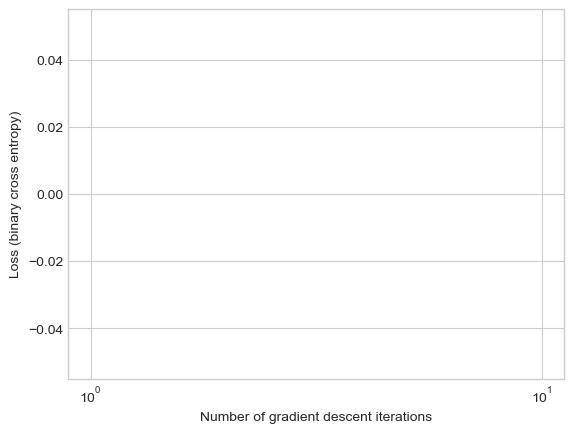

In [133]:
# instantiate model and optimizer
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

# iterable
iterations = 1000

# keep track of loss across iterations for plotting
loss_vec = []

# training loop
for _ in range(iterations):

    # keep track of loss
    loss_vec.append(LR.loss(X, y))

    # perfomr the optimizations step
    opt.step(X, y, alpha = .1, Beta = .9)


# Plot loss over iterations
plt.plot(range(1, len(loss_vec) + 1), loss_vec, color = "red")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.show()

# Discussion